# Practical Floquet Theory: Demo
Tools, tips, and tricks for numerically simulating periodically-driven quantum systems. For more details, please refer to the [notes](https://drive.google.com/drive/folders/13KFdqEYV_USliVJZTkE3Ii6wOhVC7Dug?usp=sharing) accompanying this tutorial.

Driven nonlinear systems are ubiquitous throughout physics, and can result in a rich set of dynamical phenomena that are absent in the static case. Within superconducting qubits and circuit QED, we are often interested in understanding the effects that arise when we drive given nonlinear circuit element --- for example, the ac Stark shift or the renormalization of system nonlinearities. More generally, drives can be thought of as a powerful control knob in the cQED toolbox that allow for in-situ modification of the system Hamiltonian. Some exciting examples of recent use cases in the field include dynamical sweet spot engineering, microwave-activated 2Q gates, and realizing Kerr cat qubits, among many others.  

When the drive acting on a system is time-periodic, we can use **Floquet theory** to rigorously capture the associated dynamical effects. There are several largely equivalent ways to formulate Floquet problems; some are more amenable to numerical simulation, while others are useful to doing analytic perturbation theory. Here we focus on the former --- specifically, using the extended Hilbert space formalism developed in the lecture part of this tutorial. 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import relevant packages and set up notebook
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from qubits import *

## 0. Overview and Problem Setup


In this notebook, we will be working on developing a simple numerical simulation of a driven transmon qubit. Using the tools from Floquet theory, we will build up a simple simulator that allows us to construct the effective Hamiltonian of a driven qubit and diagonalize it to get the quasi-energy spectrum. 

This notebook is broken into several short sections:
1. **Transmon Physics:** Here, we will build up a `Transmon` qubit object, and verify its properties. 
2. **Setting Up the Floquet System:** Here, we will write a model for a driven qubit and construct the effective Hamiltonian $H_{\rm eff}$ associated with it. 
3. **Numerical Diagonalization:** After creating $H_{\rm eff}$, we diagonalize it and perform quantum number assignment (i.e. state assignment). 
4. **Verifying Floquet properties:** We check that the various commutation relations and Floquet theorems work.
4. **Plotting Energy Spectra**: We apply the tools from steps 1-3 to simulate the ac-Stark shift of an off-resonantly driven transmon qubit. 



In each section, you will have some short coding problems to work on. Most of this involves filling out the empty code blocks below, as well as testing out various parameters for the simulation. 

Finally, note that we set $h = 1$, and _use GHz for all energy/frequency parameters_ below! In order to make sure that you are careful with units, we have defined some helpful constants: `GHz = 1`, `MHz = 1e-3`, and `kHz = 1e-6`. 




## 1. Transmon Physics
We begin by defining the transmon qubit via its Hamiltonian
$$
\hat{H}_0 = 4 E_C\big(\hat{n} - n_g\big)^2 - E_J \cos(\hat{\varphi})
$$
In the transmon regime, we require $E_C \ll E_J$. In this limit, charge dispersion is suppressed exponentially and so the spectrum of $\hat{H}_0$ should be insensitive to $n_g$; so we can just set it to zero throughout here.

In the charge basis $\{|n\rangle\}$, the dimensionless charge operator $\hat{n}$ can be expressed
$$
\hat{n} = \sum\limits_{n=-\infty}^{\infty} n |n\rangle\!\langle n |
$$
such that $\hat{n}|n\rangle = n|n\rangle$. In this basis, periodic function of the conjugate phase operator $\hat{\varphi}$ have delocalized charge representation. More concretely, this means we can write:

$$
\cos(\hat{\varphi}) = \frac{1}{2}\Big[e^{i\hat{\varphi}} + e^{-i\hat{\varphi}}\Big] = \frac{1}{2}\sum\limits_{n=-\infty}^{\infty} \Big[ |n+1\rangle\!\langle n| + |n\rangle\!\langle n + 1|\Big]
$$

Numerically, we must work with a finite charge truncation $N_{\rm max}^{\rm charge}$. 

**Prob. 1.1:** Read through the code snippet below for defining the `Transmon` qubit class, and take some time to make sure you understand how it is set up. `Transmon` inherits some helper functions from a `Qubit` class already written for you. Then, **fill out the `build_ops()` function:**
- [ ] **(a)** Construct the truncated charge operator $\hat{n}$.
- [ ] **(b)** Construct the truncated $\cos(\hat{\varphi})$ operator.
- [ ] **(c)** Construct identity operators of the correct dimensions for the charge and energy bases.

**Prob. 1.2:** Write a function `get_H()` to construct the transmon Hamiltonian above in the charge basis, using the operators you defined above. 

In [6]:
class Transmon(Qubit):
    """
    Transmon qubit class. 
    
    Args:
        params (Dict): Dictionary of parameters defining the qubit
    
    On init:
        - Runs build_ops() function. All operators can be saved in dictionary self.ops
        - Generates empty results dictionary self.eig_system 
    """
    
    expected_params = ["Ej", "Ec", "ng", "N_max_charge"]

    def __init__(self, params: Dict[str, Any]):
        # Initialize self.params for storing all system parameters
        self.params = params.copy()
        
        # Set the energy eigenbasis truncation if not specified
        if "N_max" not in self.params:
            self.params["N_max"] = 2 * self.params["N_max_charge"] + 1
        else:
            # Ensure energy eigenbasis dim is not greater than total charge dim
            assert self.params["N_max"] <= 2 * self.params["N_max_charge"] + 1
        super().__init__(self.params)

    
    # Build Transmon Operators
    # ==========================================
    def build_ops(self):
        self.ops["N"] = self.calc_n_op()
        self.ops["cos(φ)"] = self.build_cos_phi_op()
        self.ops["Id_charge"] = qt.qeye(2 * self.params["N_max_charge"] + 1)
        self.ops["Id"] = qt.qeye(self.params["N_max"])

    def calc_n_op(self):
        # We define the charge operator N = ∑ₙ n|n><n| in the charge basis
        N_max_charge = self.params["N_max_charge"]
        return qt.Qobj(np.diag(np.arange(-N_max_charge, N_max_charge + 1)))

    def build_cos_phi_op(self):
        # We define cos(φ) = 1/2 * ∑ₙ|n><n+1| + h.c. in the charge basis
        N_max_charge = self.params["N_max_charge"]
        return 0.5 * qt.Qobj(
            np.eye(2 * N_max_charge + 1, k=1) 
            + np.eye(2 * N_max_charge + 1, k=-1)
        )
    
    @property
    def phi_zpf(self):
        """
        Returns the phase zero-point fluctuation of the transmon.
        """
        Ec = self.params["Ec"]
        Ej = self.params["Ej"]
        return (2*Ec / Ej)**(1/4)
    
    @property
    def n_zpf(self):
        """
        Returns the charge zero-point fluctuation of the transmon.
        """
        Ec = self.params["Ec"]
        Ej = self.params["Ej"]
        return np.sqrt(np.sqrt((Ej / (32*Ec))))
    
    
    # System Hamiltonian Definitions
    # ==========================================
    def get_H(self):
        """
        Method for constructing the transmon Hamiltonian H₀ = 4*Ec*(n - ng)² - Ej*cos(φ) 
        in the charge basis.
        """
        Ej = self.params["Ej"]
        Ec = self.params["Ec"]
        ng = self.params["ng"]

        return (
            4 * Ec * (self.ops["N"] - ng * self.ops["Id_charge"]) ** 2
            - Ej * self.ops["cos(φ)"]
        )

    @property
    def Ud(self):
        """
        Unitary change of basis matrix consisting of eigenvectors of H₀ as columns. 
        """
        return qt.Qobj(self.eig_system['vecs'])
    
    @property
    def H0(self):
        """
        Method to generate the truncated system Hamiltonian H₀ in its energy eigenbasis. 
        Note: this rescales the energies so that the ground state energy is 0.

        TODO: 3 methods to do this: via eigvals, via Ud, via op_matrix function (also Ud)
        """
        eigvals = self.eig_system['vals'] - self.eig_system['vals'][0]
        return qt.Qobj(np.diag(eigvals))

### Testing your Transmon

Tip 1: You can use `eig_system['vals']` and `eig_system['vecs']` to get the _sorted_ eigenvectors/values the Hamiltonian in `get_H`. 

Tip 2: Use the `qubit_report()` function to get (and print) the qubit 



In [8]:
N_max_charge = 15
N_max = 10
Ec = 0.19
Ej = 11.3

transmon = Transmon({"Ec": Ec, "Ej": Ej, "ng": 0, "N_max_charge": N_max_charge, "N_max": N_max})
bare_eigvals, bare_eigvecs = transmon.eig_system.values()

_ = transmon.qubit_report()

Qubit frequency ω01 = 3.9444161154545947 GHz
Qubit anharmonicity α = -215.1775922359036 MHz


In [9]:
transmon.H0

Quantum object: dims=[[10], [10]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          3.94441612  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          7.67365464  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         11.16454605  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         14.37191379  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         17.32377834
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  19.38132492  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0. 

### What to Set for Truncation?
**Prob. 1.3:** Write a function `H0` above that rewrites the system Hamiltonian in its _energy eigenbasis_ using the calculated eigensystem. Rescale all the energies so that the ground state $|0\rangle$ has energy $0$. 

**Prob. 1.4:** Play around with different values of `N_max_charge` to determine a good rule of thumb for truncation size.

In [10]:
# TODO: Try to get this to be diagonal!
transmon.H0

Quantum object: dims=[[10], [10]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          3.94441612  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          7.67365464  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         11.16454605  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         14.37191379  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         17.32377834
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  19.38132492  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0. 

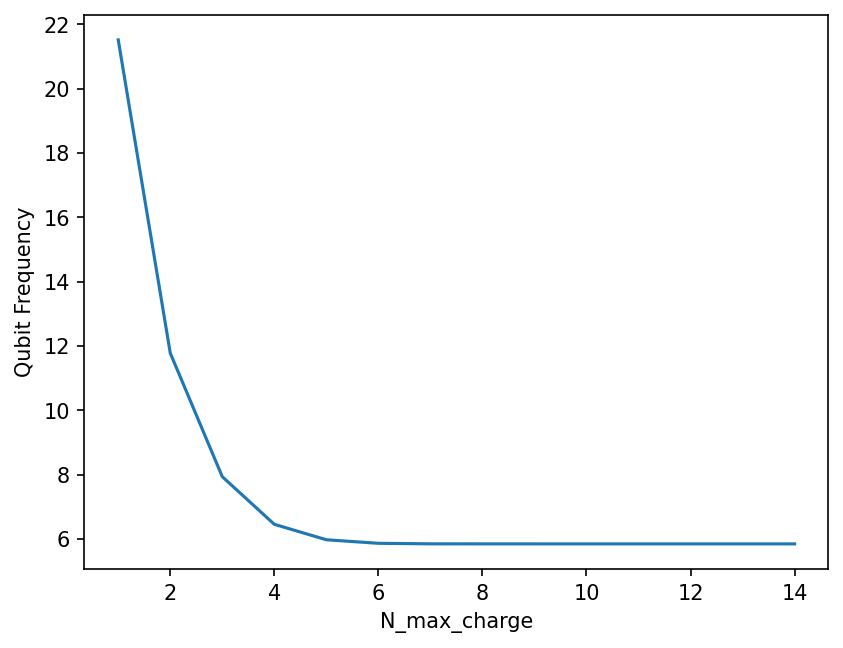

In [11]:
# Optional TODO: Test out what to choose for N_max_charge here. 

cutoff_list = np.arange(1, 15)

freqs = []
for c in cutoff_list:
    t = Transmon({"Ec": 0.15, "Ej": 30, "ng": 0, "N_max_charge": c})
    
    evals = t.eig_system['vals']
    omega_01 = evals[1] - evals[0]
    
    freqs.append(omega_01)

plt.plot(cutoff_list, freqs)
plt.xlabel("N_max_charge")
plt.ylabel("Qubit Frequency")
plt.show()

## 2. Setting up a Floquet Hamiltonian

Following the lecture, we now consider the time-dependent Hamiltonian of the driven transmon:

$$
\begin{aligned}
\hat{H}(t) &= \hat{H}_0 + \hat{H}_d(t) \\ &= 4 E_C\big(\hat{n} - n_g\big)^2 - E_J \cos(\hat{\varphi}) + \Omega \hat{\mathcal{Q}}\cos(\omega t)
\end{aligned}
$$

Here, the drive is periodic with period $T = 2\pi / \omega$, and has a drive amplitude $\Omega$. The operator $\hat{\mathcal{Q}}$ represents the drive coupling, i.e. what variable is being driven. For a transmon pumped through a capacitively coupled tranmission line, we typically take $\hat{\mathcal{Q}} = \hat{n} \, \sim \, in_{\rm zpf}(\hat{b}^\dagger - \hat{b})$.


From the Floquet theorem, we know that the above Hamiltonian admits a set of quasi-energies and Floquet modes that are solutions of the Schrodinger equation:

$$
|\psi_\alpha(t)\rangle = e^{-i\epsilon_\alpha t/\hbar}\,\, |u_\alpha(t)\rangle
$$

where $\epsilon_\alpha$ are called the quasi-energies (unique mod. $\hbar \omega_d)$ and $|u_\alpha\rangle$ are called the Floquet modes that are time-periodic: $|u_\alpha(t)\rangle = |u_\alpha(t + T)\rangle$. We can rewrite the Schrodinger equation:

$$
\Big[H(t) - i\hbar\partial_t\Big] |u_\alpha(t)\rangle = \epsilon_\alpha |u_\alpha(t)\rangle
$$

and the Hamiltonian on the right hand side is known as the effective Hamiltonian $\hat{H}_{\rm eff} \equiv H(t) - i\partial / \partial t$. 

Next, following the lecture, we can rewrite $\hat{H}_{\rm eff}$ in the extended Hilbert space, where we promote $\theta(t) = \omega t$ to an independent degree of freedom, i.e. promote it to an operator $\theta \to \hat{\theta}$. In this case, we have 

$$
-i \frac{\partial}{\partial t} = -i \omega \frac{\partial}{\partial(\omega t)} = -i\omega \frac{\partial}{\partial \theta}
$$

But this is just the operator conjugate to $\hat{\theta}$! That is, we can rewrite $-i\partial/\partial t$ by $\omega \hat{M}$ where $\hat{M}$ is the drive 'charge' operator with $[\hat{\theta}, \hat{M}] = i$. Under this mapping, we can rewrite

$$
\hat{H}_{\rm eff} = \hat{H}_0 + \Omega \hat{\mathcal{Q}} \cos(\omega t) - i\frac{\partial}{\partial t}
$$
as 
$$
\hat{H}_{\rm eff} = \hat{H}_0 + \Omega \hat{\mathcal{Q}} \cos(\hat{\theta}) + \omega \hat{M}
$$

in the extended space. We can also rewrite $\cos(\hat{\theta})\equiv \big[\hat{m}_+ + \hat{m}_-\big]$ where these operators have the form of $e^{\pm i\hat{\theta}}$. 

Note that the eigenstates of $\hat{H}_{\rm eff}$ when $\Omega = 0$ will have the form $|\alpha\rangle\otimes |m\rangle$ where $|\alpha\rangle$ are qubit eigenstates, and $|m\rangle$ are the drive's "charge" states. The coupling between the qubit and drive gets turned on when $\Omega$ is nonzero, and will cause qubit and drive states to hybridize.


____________________________________________________________________________________________________________________

**Prob. 2.1:** Read through the code snippet below for defining the `DrivenQubit` class, and take some time to make sure you understand how it is set up. Then fill out the sections of `build_ops_and_states()` below:
- [ ] Construct the drive "charge" operator $\hat{M}$
- [ ] Construct the operators $\hat{M}_+$, $\hat{M}_-$, and $\cos(\theta) \equiv \frac{1}{2}[\hat{M}_+ + \hat{M}_-]$


**Prob. 2.2:** Construct the function `H_eff` below to build up the effective Hamiltonian of the system. To do so, use the properties `H0` and `H_d` as building blocks. 

In [12]:
class DrivenQubit(DrivenSystem):
    """
    Driven qubit class for constructing Floquet Hamiltonian.

    Args:
        params (Dict): Dictionary of parameters defining the driven qubit
        qubit (Qubit): Bare quantum system (i.e. Transmon) object
        drive_coupling (qt.Qobj): Operator coupling to the drive. Note that 
                                  drive_coupling is NOT a composite operator
                                  and should have the dimension of the qubit.
    
    On init:
        - Runs build_ops_and_states()
        - Generates analysis dictionaries
    """
    expected_params = ["M_max"]
    
    # Build drive operators and states
    # ==========================================        
    def build_ops_and_states(self):
        """
        Method to construct drive operators in the extended Hilbert space.
        """
        M_max = self.params["M_max"]

        # Construct M = ∑ₘ m|m><m| operator in drive charge basis
        self.ops["M"] = qt.Qobj(np.diag(np.arange(-M_max, M_max + 1)))
        
        # Construct Id = ∑ₘ|m><m| in the drive charge basis
        self.ops["Id_drive"] = qt.Qobj(np.identity(2 * M_max + 1))

        # Construct M₊ and M₋ operators for drive
        self.ops["M-"] = qt.Qobj(np.eye(2 * M_max + 1, k=1))
        self.ops["M+"] = qt.Qobj(np.eye(2 * M_max + 1, k=-1))
        
        # Construct cos(θ) ≡ 1/2 * [M₊ + M₋] = 1/2 * ∑ₘ|m+1><m| + h.c
        self.ops["cos(θ)"] = 0.5 * (self.ops["M+"] + self.ops["M-"])

        # Construct |m=0⟩ Floquet mode, corresponding to zero drive photons.
        self.states["m=0"] = qt.basis(2 * M_max + 1, M_max)

        # Construct bare basis vectors and energies
        bare_eigvals, bare_eigvecs = self.qubit.H0.eigenstates()
        self.states["bare_basis"] = [qt.tensor(ev, self.states["m=0"]) for ev in bare_eigvecs]
        self.bare_energies = bare_eigvals
        
    
    # Effective Hamiltonian Definitions
    # ==========================================
    @property
    def H0(self):
        """
        Method to generate the bare system Hamiltonian H₀ ⊗ Id in the extended space
        """
        return qt.tensor(self.qubit.H0, self.ops["Id_drive"])
    
    @property
    def H_d(self):
        """
        Method to generate the operator part of the drive Hamiltonian H_d(t) in the extended 
        space. That is, for H_d(t) = Ω*Q*cos(ωt) and θ = ωt, we return Q ⊗ cos(θ). 
        
        Returns:
            Q ⊗ cos(θ) (qt.Qobj): Operator part of H_d; here Q is the drive_coupling.
        """
        return qt.tensor(self.ops["drive_coupling"], self.ops["cos(θ)"])
    
    def H_eff(self, omega: float, drive_amp: float):
        """
        Method to construct effective Hamiltonian H_eff = H₀ + H_d - i[∂/∂t] = H₀ + H_d + ωM
        in the extended space. 
        
        Args:
            omega (float): Drive frequency
            drive_amp (float): Drive amplitude 
        """
        M_composite = qt.tensor(self.qubit.ops["Id"], self.ops["M"])
        return self.H0 + (drive_amp * self.H_d) + (omega * M_composite)
    
    # Analysis
    # ==========================================
    def get_state_idxs(self, omega: float):
        """
        Method to get the indices of the basis states |α⟩⊗|m⟩ for all m, at zero drive amplitude
        Ω = 0. This is done by computing the closest energies to the known energies. 
        """
        M_max = self.params["M_max"]
        
        H_eff_0 = self.H_eff(omega, 0)
        eigvals, eigvecs = H_eff_0.eigenstates()

        idxs = {}
        for i, E in enumerate(self.bare_energies):
            for m in range(-M_max, M_max+1):
                idx_min = np.argmin(
                    [np.abs(E + m*omega - eigval) for eigval in eigvals]
                )
                idxs[(i, m)] = idx_min
                
        return idxs

### Testing your Floquet Qubit

The `DrivenQubit` object uses the `H0` method of its qubit to define the bare basis. That is, it expects the `Transmon` to be written in its eigenbasis. Recall that constructed $\hat{H}_0 \to \hat{U}_d^\dagger \hat{H}_0 \hat{U}_d$, where $\hat{U}_d$ is a unitary to diagonalize the system. 


**Prob 2.3:**  The `drive_coupling` operator below is set to $\hat{n}$. However, this is written in the original charge basis, not the energy eigenbasis. Modify it so that it is correct: $\hat{\mathcal{Q}} = \hat{U}_d^\dagger\hat{n}\hat{U}_d$. 

Hint: use `transmon.Ud` or the pre-built function `transmon.op_matrix_in_H_eigenbasis`

In [13]:
# TODO: Fill in the correct Q operator here
drive_coupling = transmon.op_matrix_in_H_eigenbasis(transmon.ops["N"])

In [14]:
# Set up the Floquet qubit
M_max = 15
fq = DrivenQubit({"M_max": M_max}, transmon, drive_coupling)

## 3. Numerical Diagonalization and State Assignment

In [15]:
ω01, α = transmon.qubit_report()
fq.bare_energies

Qubit frequency ω01 = 3.9444161154545947 GHz
Qubit anharmonicity α = -215.1775922359036 MHz


array([ 0.        ,  3.94441612,  7.67365464, 11.16454605, 14.37191379,
       17.32377834, 19.38132492, 22.76527713, 23.04311607, 29.1508744 ])

For a quantum system $\hat{H}_0$ is driven via $\hat{H}_d(t) = \Omega \hat{\mathcal{Q}}\cos(\omega t)$, we have shown that the this is equivalent to the effective Hamiltonian $H_{\rm eff} = H_{\rm eff}(\omega, \Omega)$. In the case that $\dim(\hat{H}_0) = N_{\rm max}$ and $\dim(\hat{H}_d) = D \equiv 2M_{\rm max} + 1$, we expect $\dim(H_{\rm eff}) = N_{\rm max} \times D$. 

Now, if we diagonalize $H_{\rm eff}$ at a given $(\omega, \Omega)$, we will get $N_{\rm max} \times D$ unlabelled eigenvalues  and eigenvectors. **How do we identify which of these correspond to which states?** One way to do this is to compare the eigenenergies $\lambda_1, \lambda_2, \ldots, \lambda_{N_{\rm max} D}$ with the known "bare" energies of the system, when the drive is turned off (i.e. $\Omega \to 0$). 

Specifically, we know
$$
\hat{H}_{\rm eff}(\omega, \Omega) = \hat{H}_0 + \Omega \hat{\mathcal{Q}} \cos(\hat{\theta}) + \omega \hat{M}
$$
has eigenstates $|\alpha\rangle\otimes |m\rangle$ and eigenenergies $\epsilon_\alpha + m\omega$.

There are thus two methods to identify which states are which:
1. Compare the eigenvectors $|V_1\rangle, \ldots, |V_{N_{\rm max}D}\rangle$ to the fixed basis $|\alpha\rangle\otimes |m\rangle$. 
2. Compare the eigenenergies $\lambda_1, \ldots, \lambda_{N_{\rm max} D}$ to the fixed energies $\epsilon_\alpha + m\omega$. 

In the second case, we can do this by solving the optimization:

$$
{\rm index}(\alpha, m) = {\rm argmin}_{\lambda} \,\big|\epsilon_\alpha + m\omega - \lambda\big|
$$

**Prob. 3.1:** Implement the above minimization above:

In [28]:
ω01


np.float64(3.9444161154545947)

In [29]:
# Drive frequency
ωd = 7.4 #ω01 + 200 * MHz
H_eff_0 = fq.H_eff(ωd, 0)

eigvals, eigvecs = H_eff_0.eigenstates()

idxs = {}
for alpha, E_alpha in enumerate(fq.bare_energies):
    for m in range(-M_max, M_max+1):
        idx_min = np.argmin(
            [np.abs(E_alpha + m*ωd - eigval) for eigval in eigvals]
        )
        idxs[(alpha, m)] = idx_min

In [30]:
# Test this out below by playing with some values of eigvals[idxs[(α, m)]]


## 4. Verify Floquet State Properties

Recall that $[\hat{M}_+, \hat{M}_-] = 0$ and $[M, M_{\pm}] = \pm M_{\pm}$. Furthermore, we have 

$$
M_+ |m\rangle = |m+1\rangle; \qquad M_- |m\rangle = |m-1\rangle
$$

Recall that we have stored the eigenvectors $|\alpha\rangle\otimes |m\rangle$ in the dictionary `eigvecs[idxs[(α, m)]]`. Try to test out the commutation relations and equations above, e.g. by computing matrix elements of $M_{\pm}$ with the $|\alpha\rangle\otimes |m\rangle$ states.


In [31]:
M_plus = qt.tensor(fq.qubit.ops["Id"], fq.ops["M+"])
M_min = qt.tensor(fq.qubit.ops["Id"], fq.ops["M-"])

In [32]:
eigvecs[idxs[(0, 1)]].dag() * M_plus * eigvecs[idxs[(0, 1)]]

0j

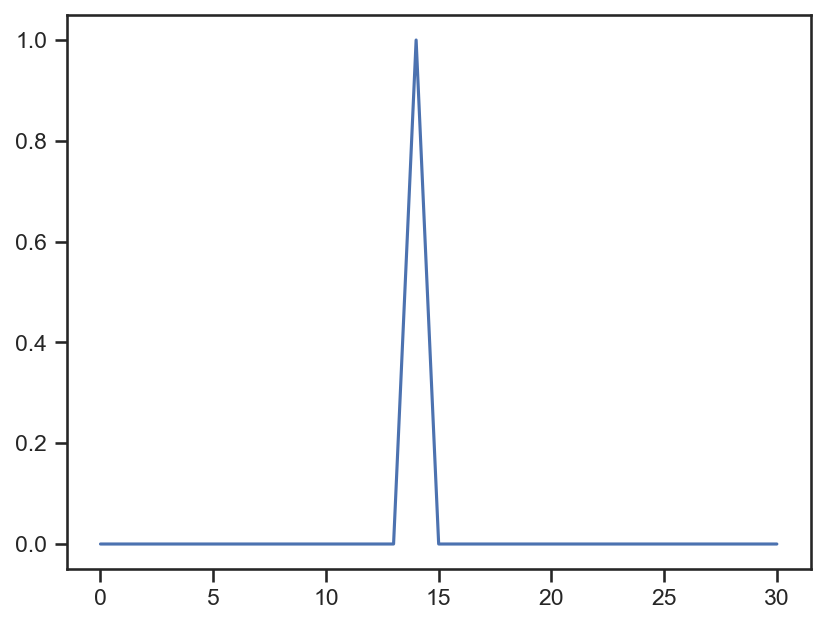

In [33]:
# Verify the properties here 
overlaps = [np.abs(M_plus.matrix_element(eigvecs[idxs[(0, 0)]], eigvecs[idxs[(0, m)]])) for m in range(-M_max, M_max + 1)]

plt.plot(overlaps)

## 5. Plotting ac-Stark Shift

In [38]:
### Code for Plotting
drive_amps = np.linspace(0, 0.2, 26)
drive_freq = 7.4# ω01 + 200*MHz 

idxs = fq.get_state_idxs(drive_freq)
bare_basis_idxs = [idxs[(alpha, 0)] for alpha, _ in enumerate(fq.bare_energies)]

# Additional array of all quasi-energies
all_quasi_energies = []

total_energies = []
total_states = []
for drive_amp in drive_amps:
    
    H_eff = fq.H_eff(drive_freq, drive_amp)
    eigvals, eigvecs = H_eff.eigenstates()
    
    energies = eigvals[bare_basis_idxs]
    states = eigvecs[bare_basis_idxs]
    
    total_energies.append(energies)
    total_states.append(states)
    all_quasi_energies.append(eigvals)
    
total_energies = np.array(total_energies)
all_quasi_energies = np.array(all_quasi_energies)

In [39]:
# Extract the qubit frequencies and anharmonicities
qubit_freqs = total_energies[:, 1] - total_energies[:, 0]
anharms = total_energies[:, 2] + total_energies[:, 0] - 2*total_energies[:, 1]

In [40]:
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")
# sns.set_context("paper")

Text(0.5, 1.0, 'Floquet Quasi-Energy Spectrum')

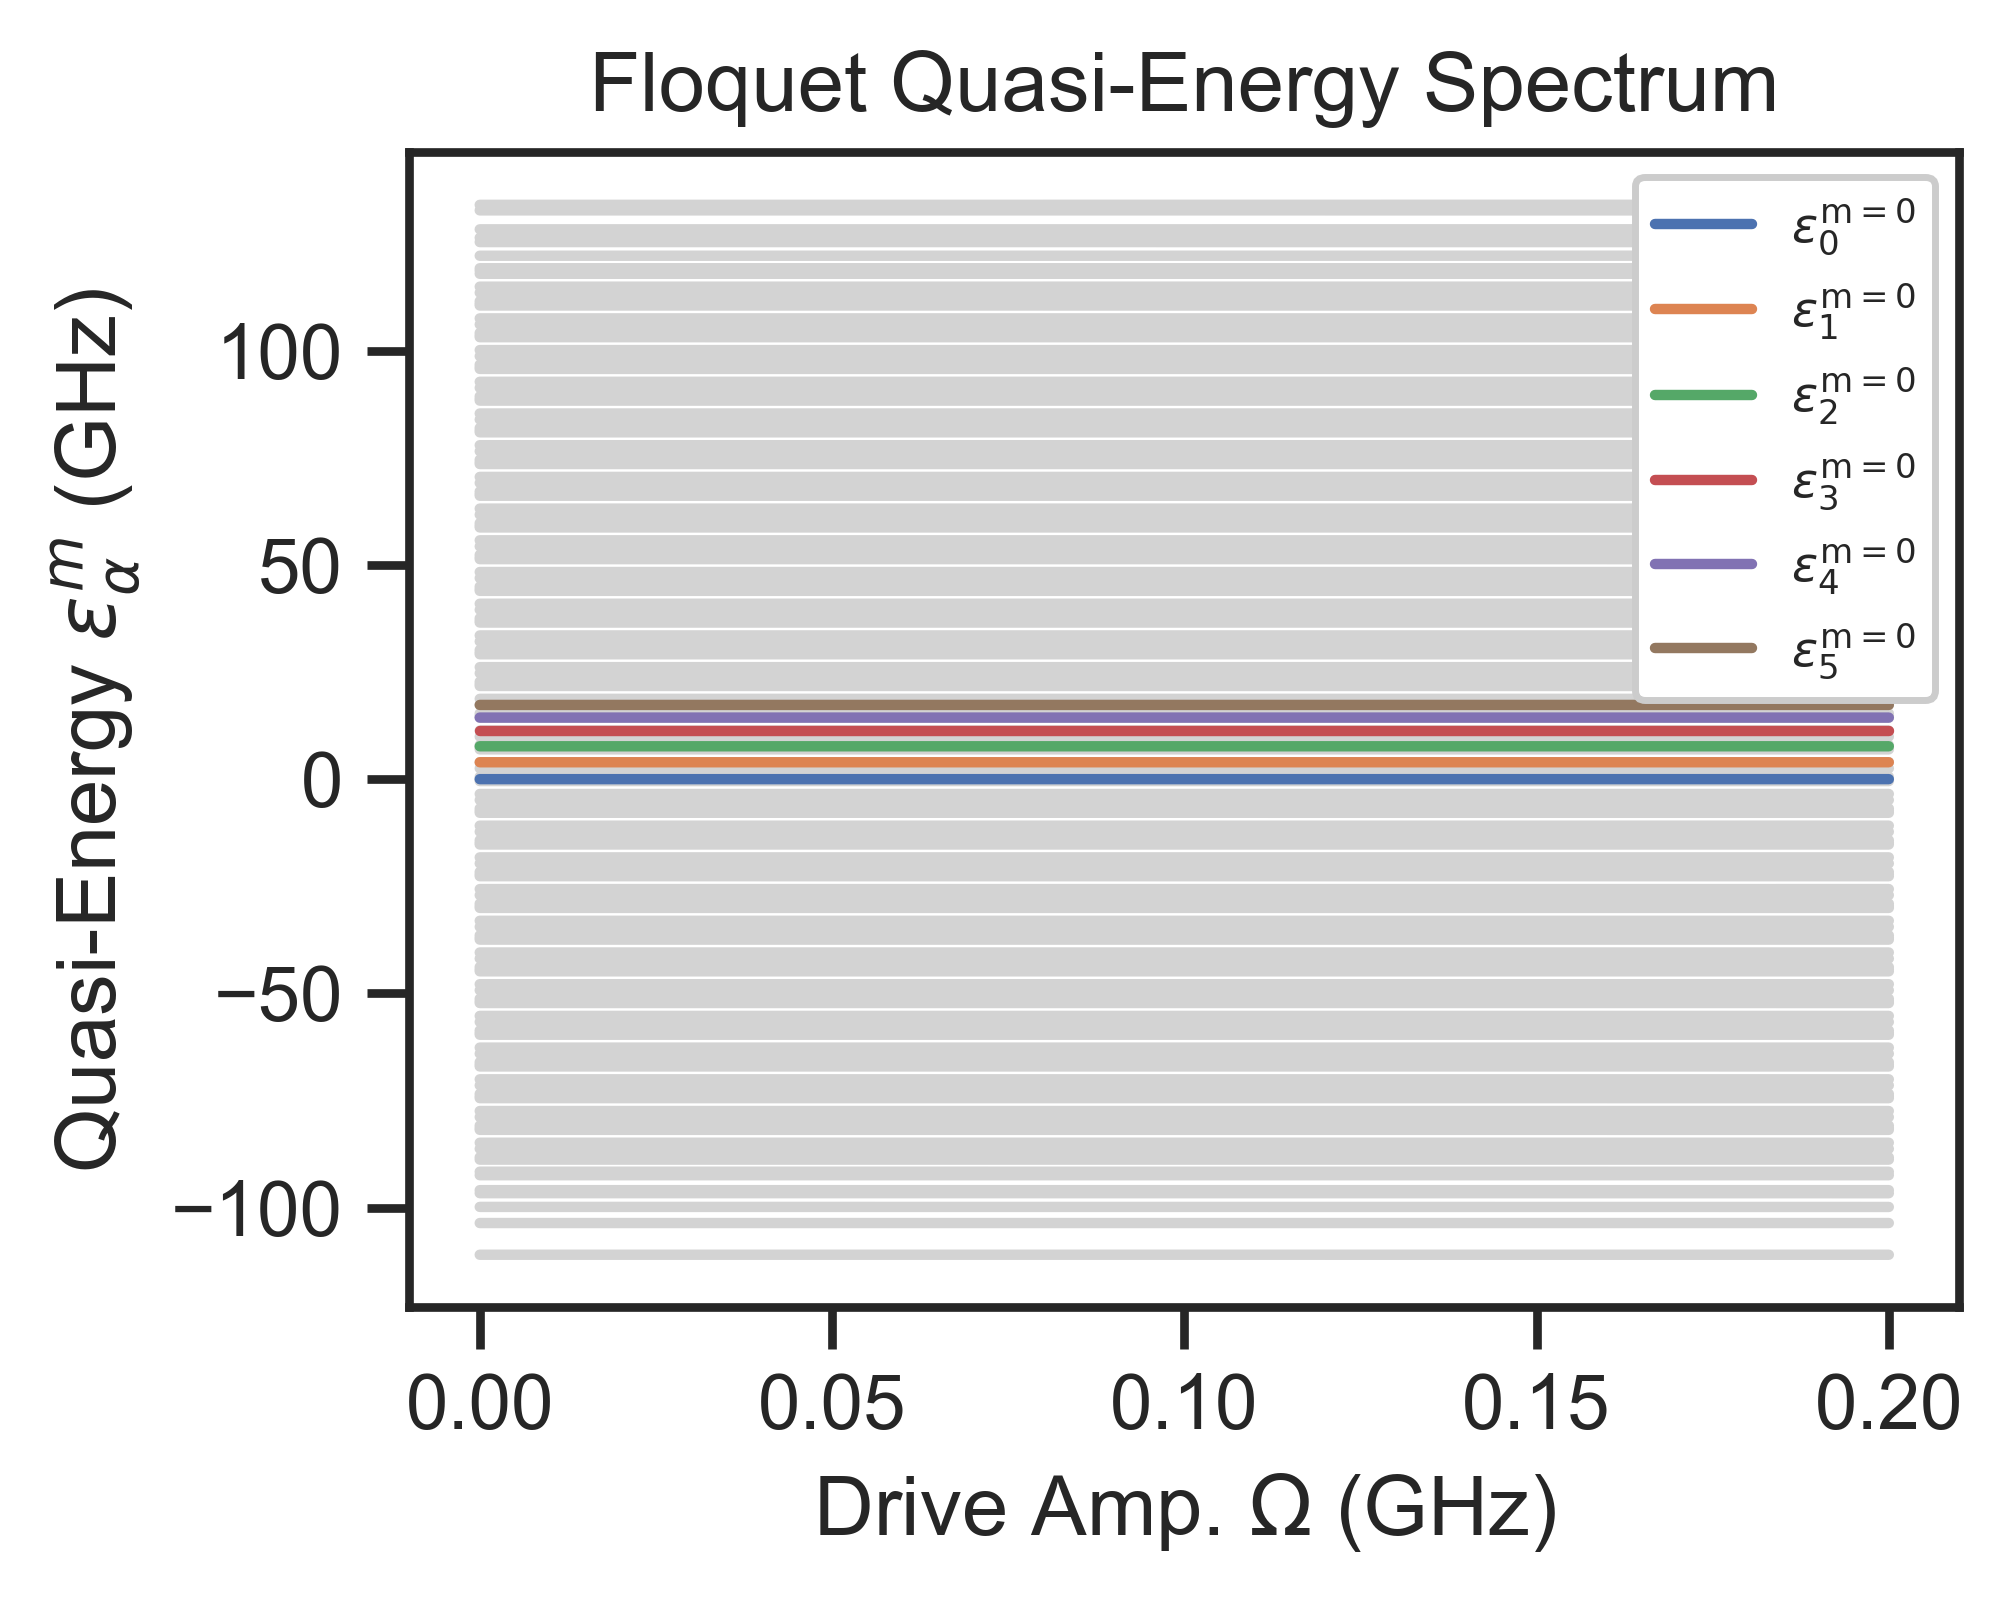

In [41]:
plt.figure(figsize=(4, 3), dpi=500)
for n in range(0, 310, 2):
    plt.plot(drive_amps, all_quasi_energies[:, n], color="lightgrey")

for n in range(6):
    plt.plot(drive_amps, total_energies[:, n], label=fr"$\epsilon_{n}^{{\rm m=0}}$")

plt.legend(loc="upper right", fontsize=7, framealpha=1)
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Quasi-Energy $\epsilon_{\alpha}^{m}$ (GHz)")
plt.title("Floquet Quasi-Energy Spectrum")

Qubit frequency ω01 = 3.9444161154545947 GHz
Qubit anharmonicity α = -215.1775922359036 MHz


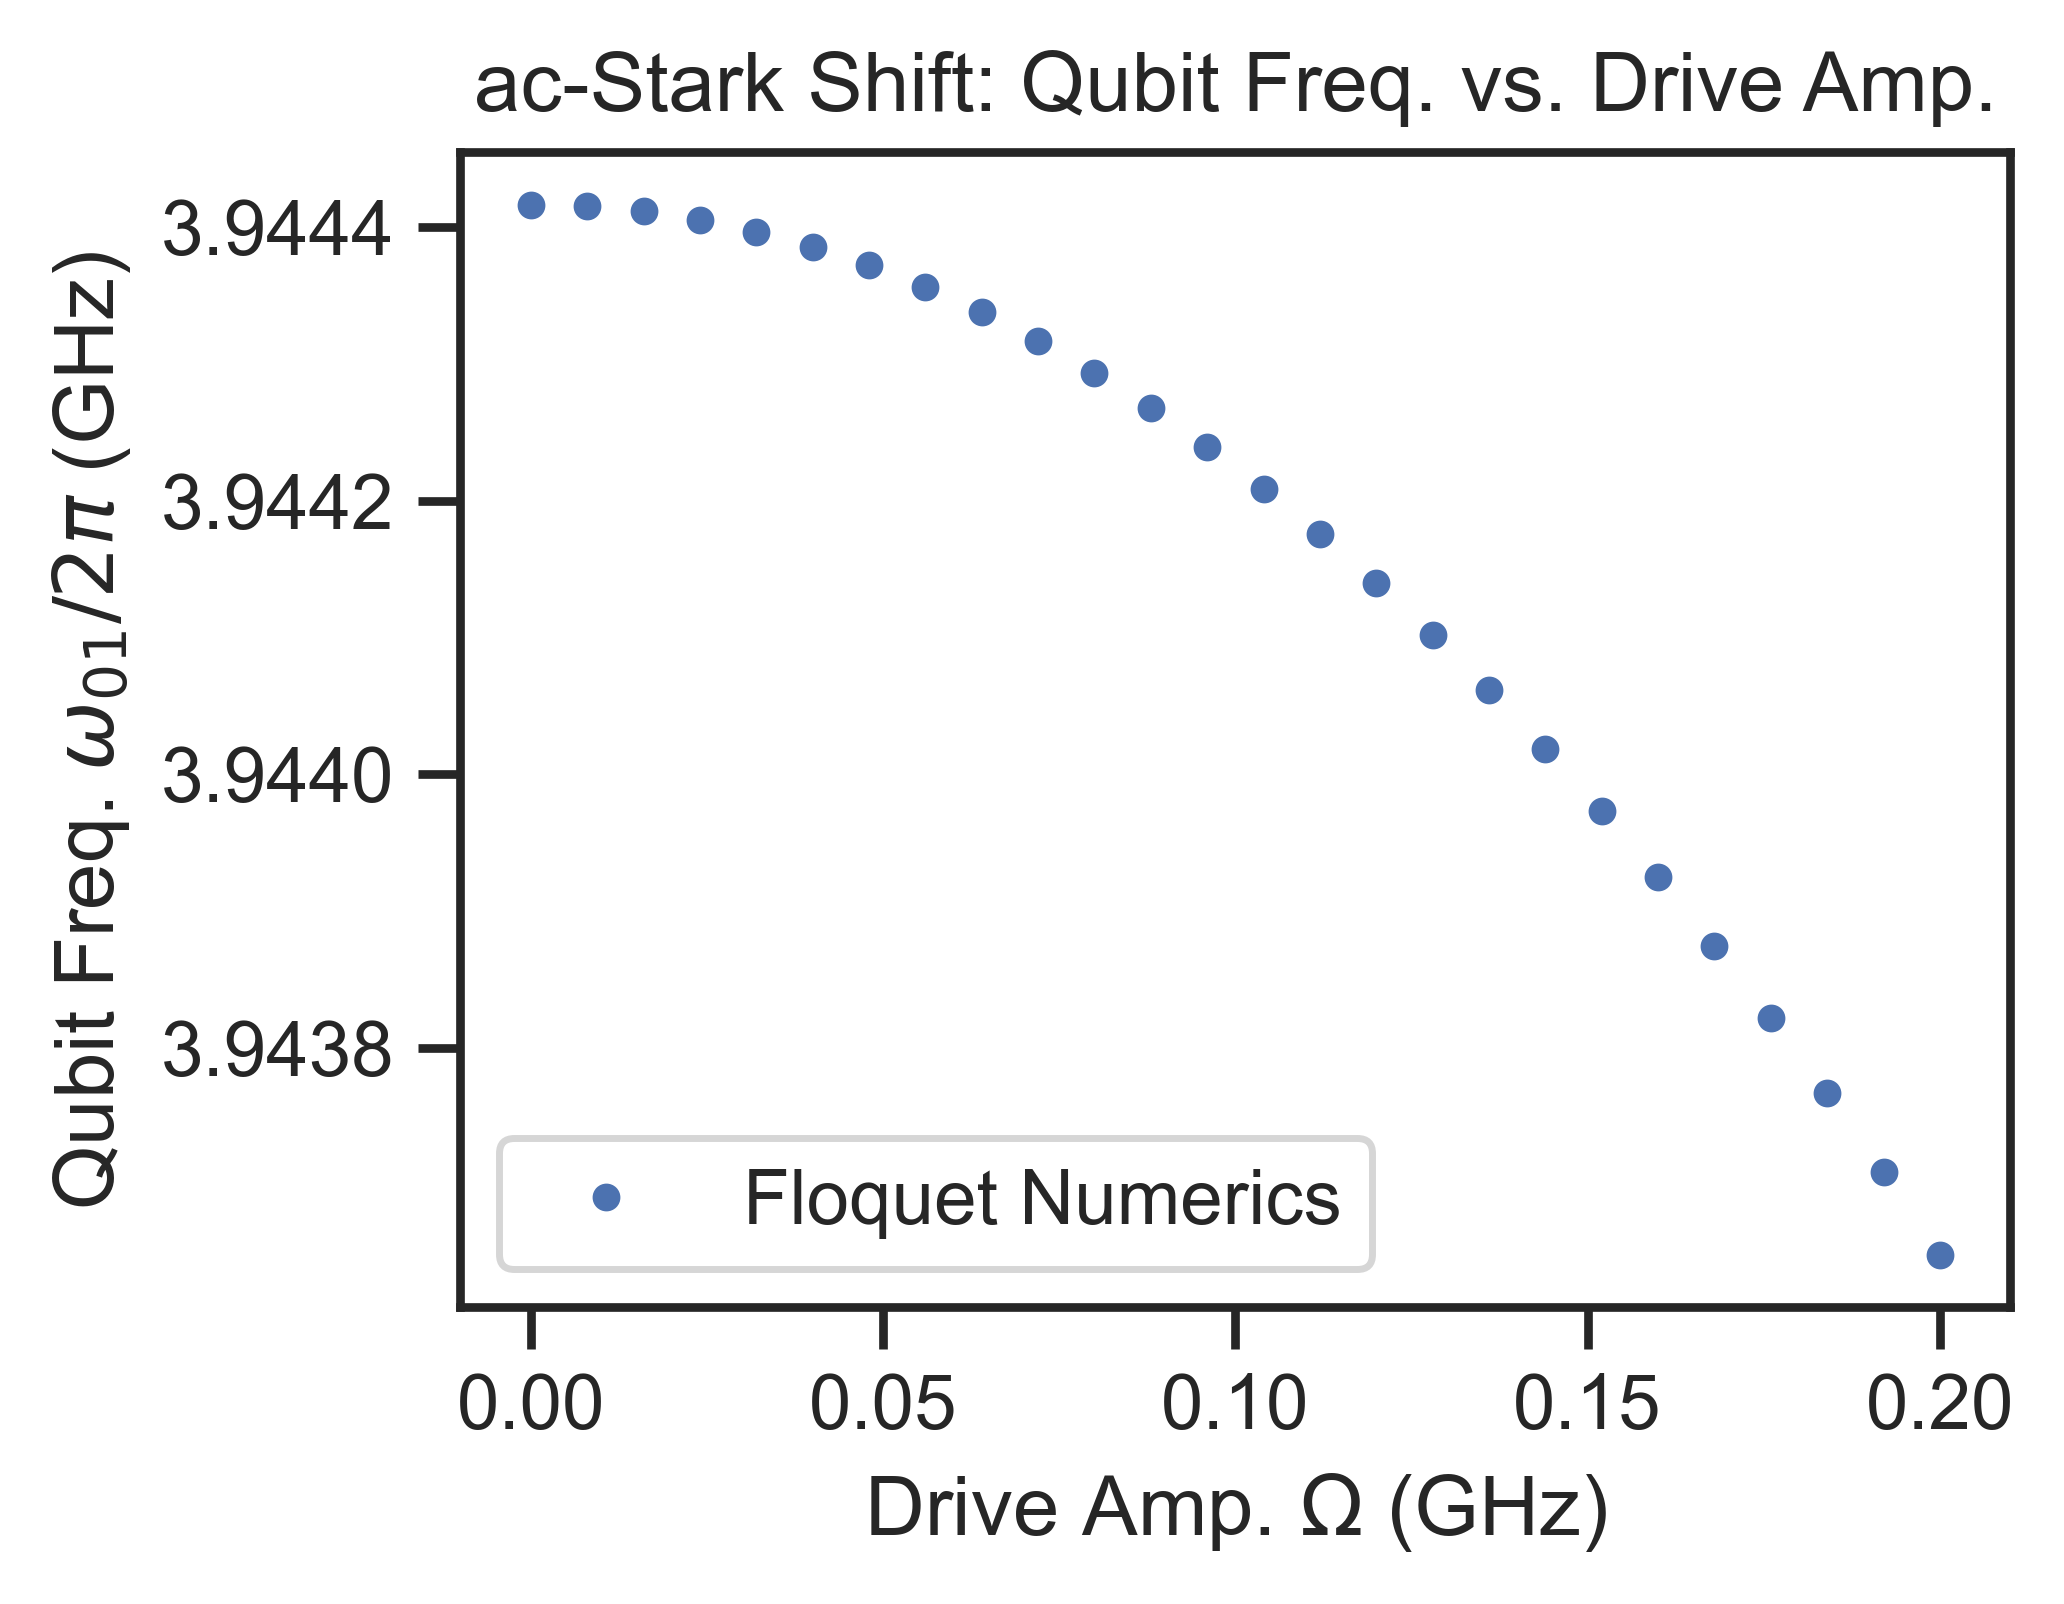

In [44]:
plt.figure(figsize=(4, 3), dpi=500)
plt.plot(drive_amps, qubit_freqs, '.', label="Floquet Numerics")
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Qubit Freq. $\omega_{\rm 01}/2\pi$ (GHz)")
plt.title(r"ac-Stark Shift: Qubit Freq. vs. Drive Amp.")


plt.legend(loc="lower left")

_ = fq.qubit.qubit_report()

We see that the qubit frequency $\omega_{\rm 01}$ decreases with increasing drive amplitude $\Omega$. Moreover, the dependence of $\omega_{\rm 01}$ on $\Omega$ is roughly quadratic to leading order, which matches analytic theory!

Qubit frequency ω01 = 3.9444161154545947 GHz
Qubit anharmonicity α = -215.1775922359036 MHz


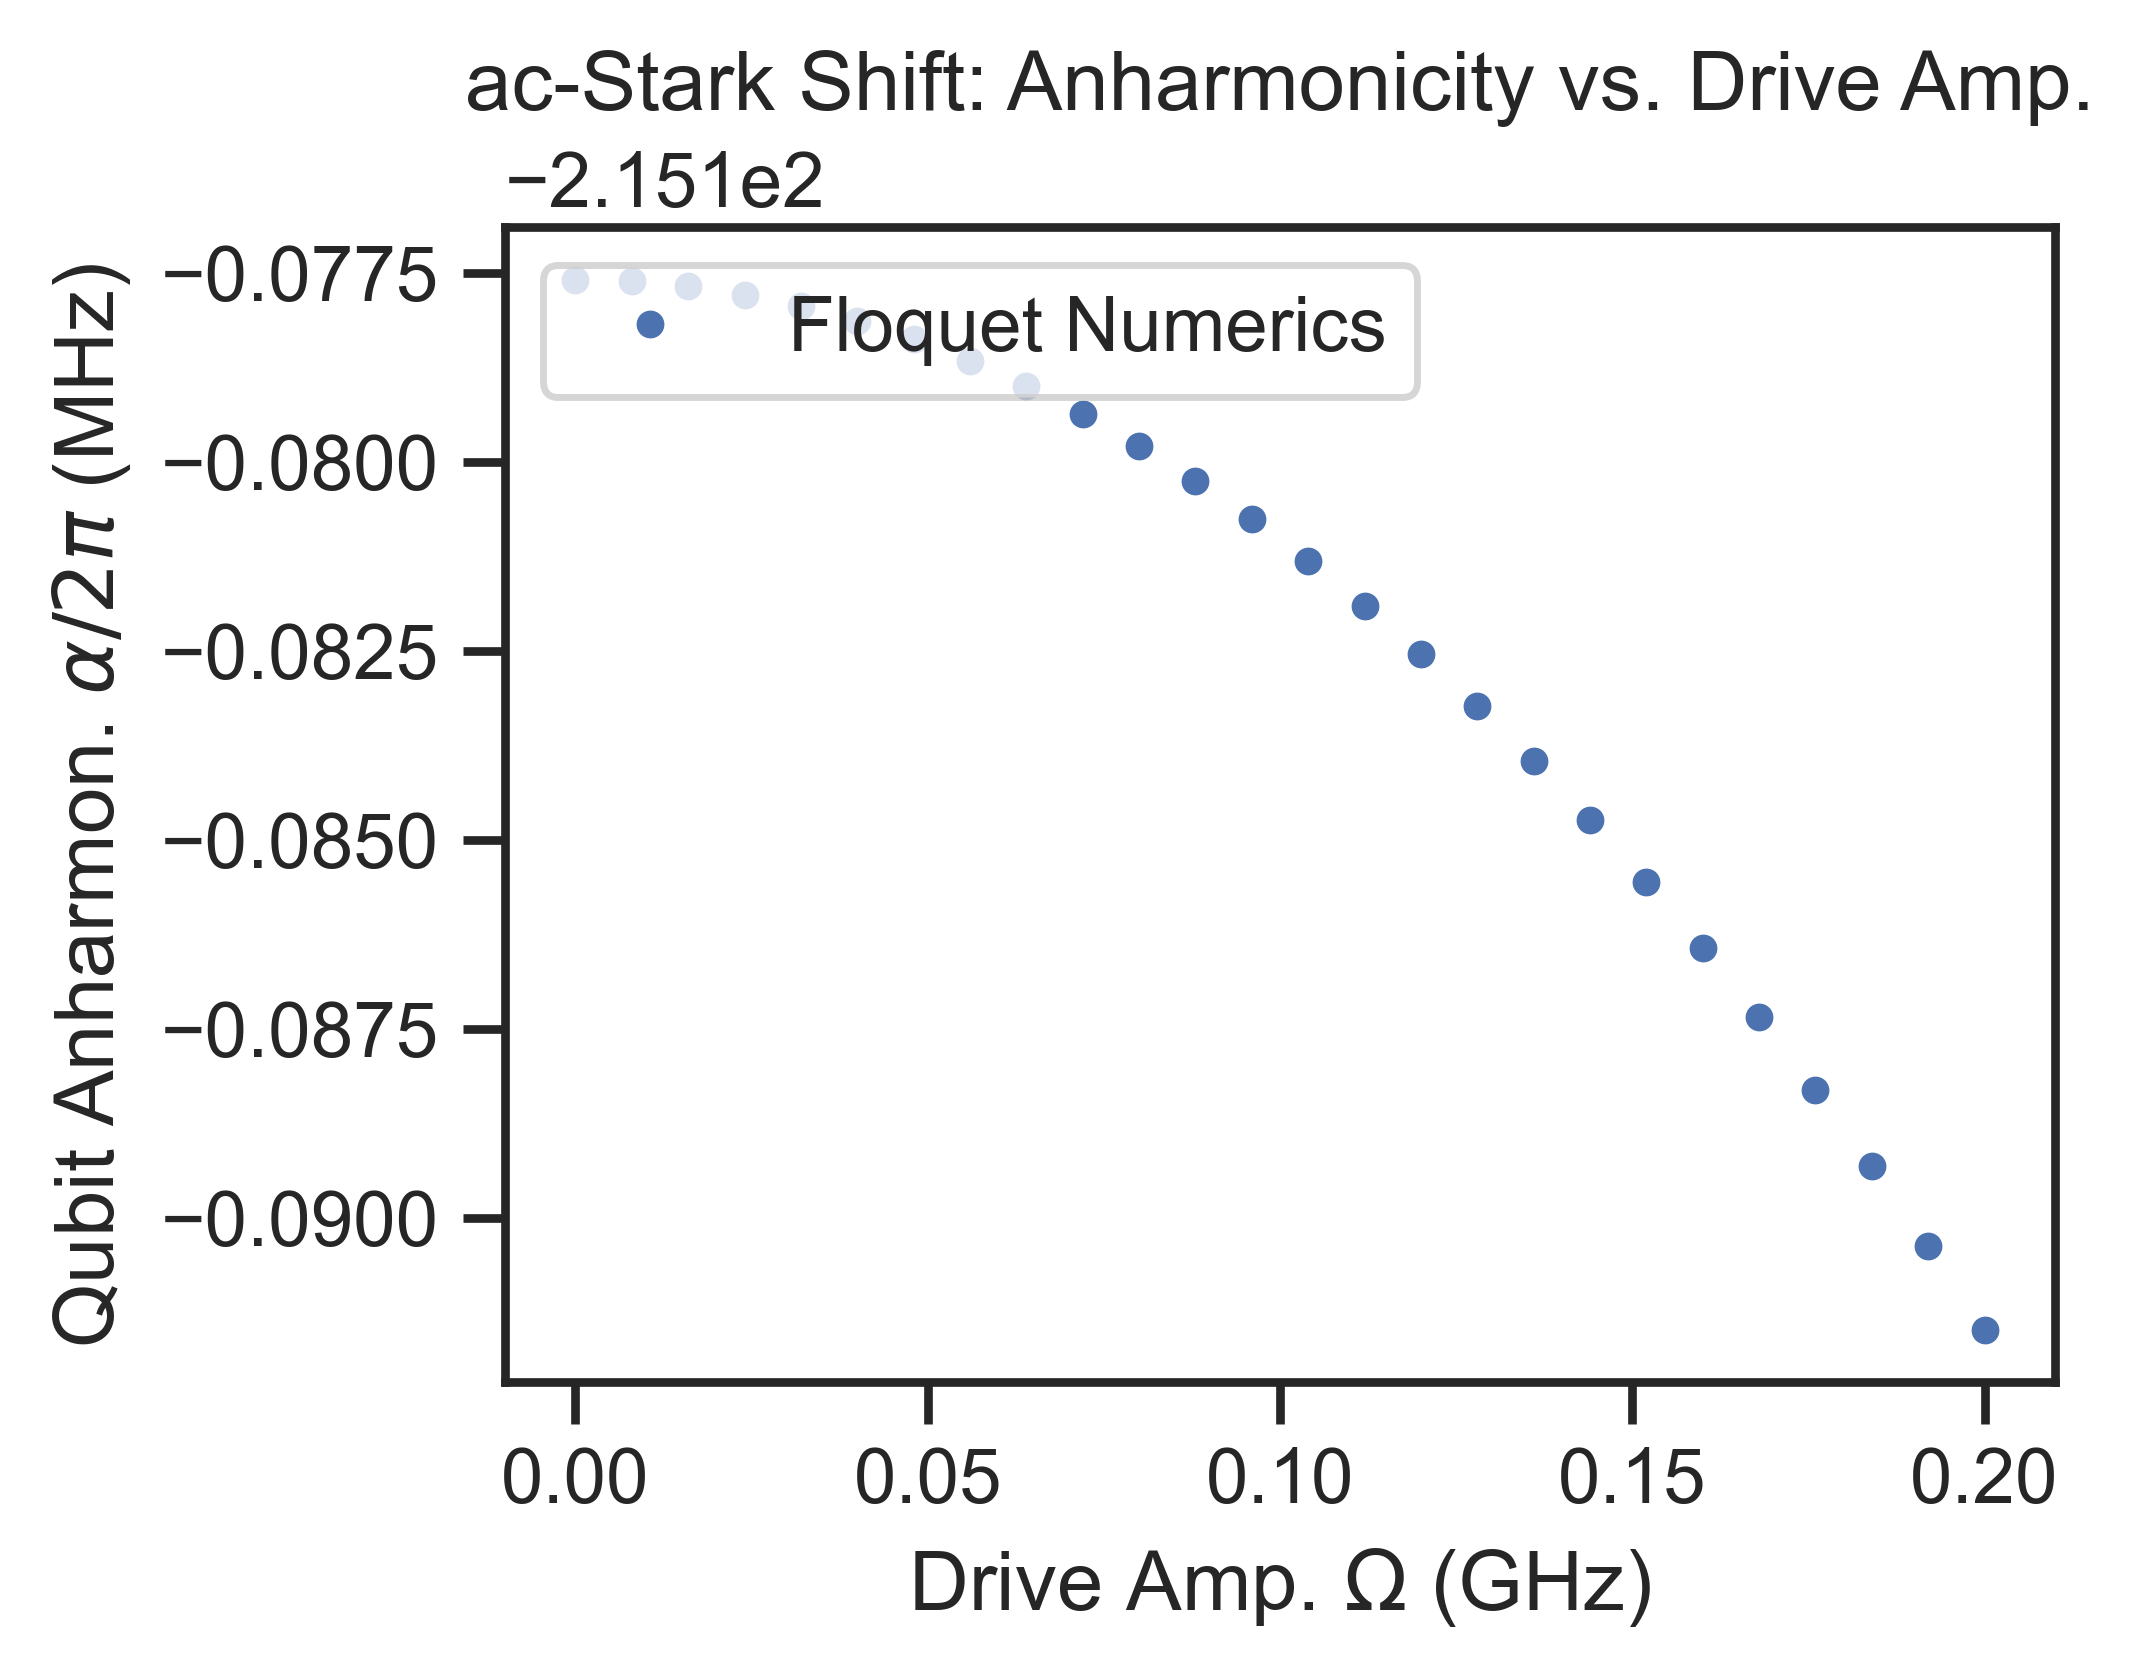

In [45]:
plt.figure(figsize=(4, 3), dpi=500)
plt.plot(drive_amps, anharms / MHz, '.', label="Floquet Numerics")
plt.xlabel(r"Drive Amp. $\Omega$ (GHz)")
plt.ylabel(r"Qubit Anharmon. $\alpha/2\pi$ (MHz)")
plt.title(r"ac-Stark Shift: Anharmonicity vs. Drive Amp.")
plt.legend(loc="upper left")


_ = fq.qubit.qubit_report()


plt.show()

## 6. Possible Extra Demos

1. Construct the Floquet propagator and compare the time-evolution to `qt.sesolve()`
2. Use perturbative operator-valued Floquet to get _analytic_ expressions for the effective Hamiltonian and system parameters. We can use this to fit the ac-Stark shift curves above. 

**For EQuS:** the code infrastructure we wrote here for simulating Floquet + qubit energy spectra is based off a similar set of tools developed by the bosonic team found in [`cavity_qubit`](https://github.mit.edu/EQuS/cavity_fluxonium). This uses some numerically optimized code in JAX for getting spectra and other properties for qubit, cavity-qubit, and driven/Floquet systems. If you're interested, please reach out to Shoumik! 